In [57]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
Chuva_Path = r'F:\Philipe\Doutorado\Dados_CHIRPS_FTP\Recortados\*.nc'

Para = xr.open_dataset(glob.glob(Chuva_Path)[0])

Para

<xarray.Dataset>
Dimensions:    (latitude: 249, longitude: 257, time: 13989)
Coordinates:
  * latitude   (latitude) float32 -9.825001 -9.775002 ... 2.5249977 2.574997
  * longitude  (longitude) float32 -58.875008 -58.825005 ... -46.125 -46.074997
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2019-04-20
Data variables:
    precip     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:       CF-1.6
    title:             CHIRP  Version 1.0
    history:           created by Climate Hazards Group
    version:           Version 1.0
    date_created:      2017-10-24
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...


In [190]:
def reduce_dimension_x(ds, x_coordinate_name='longitude', new_res=50):
    
    return ds.groupby( ((ds[x_coordinate_name]//new_res) + 0.5)*new_res).mean(dim=x_coordinate_name)
    
def reduce_dimension_y(ds, y_coordinate_name='longitude', new_res=50):
    
    return ds.groupby( ((ds[y_coordinate_name]//new_res) + 0.5)*new_res).mean(dim=y_coordinate_name)

def reduce_dimension_xy(ds, x_name='longitude', y_name='latitude' , new_res=50):
    
    return reduce_dimension_x(reduce_dimension_y(ds, y_name, new_res), x_name, new_res)
    
Para_resampled = reduce_dimension_xy(Para, new_res=2)

In [184]:
Para_resampled_mean = Para_resampled.mean(dim='time')

Para_resampled_mean

<xarray.Dataset>
Dimensions:    (latitude: 7, longitude: 7)
Coordinates:
  * latitude   (latitude) float64 -9.0 -7.0 -5.0 -3.0 -1.0 1.0 3.0
  * longitude  (longitude) float64 -59.0 -57.0 -55.0 -53.0 -51.0 -49.0 -47.0
Data variables:
    precip     (longitude, latitude) float32 6.40899 6.7028627 ... nan nan

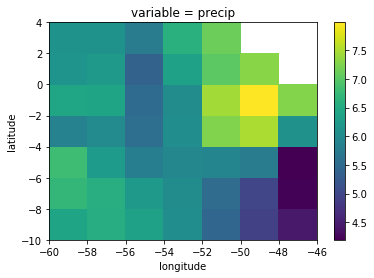

In [61]:

Para_resampled_mean_to_Array = Para_resampled_mean.to_array()

Para_resampled_mean_to_Array[0].T.plot(label=True)

# Calculating Seasonal Averages from Timeseries of Monthly Means


In [436]:
from netCDF4 import num2date

# Some calendar information so we can support any netCDF calendar.


In [437]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

# A few calendar functions to determine the number of days in each month


In [438]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

## We first have to come up with the weights, - calculate the month lengths for each monthly data record - calculate weights using groupby('time.season')


## Finally, we just need to multiply our weights by the Dataset and sum along the time dimension.

In [441]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(Para.time.to_index(), calendar='noleap'),
                            coords=[Para.time], name='month_length')

# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.season') / month_length.astype(float).groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (Para * weights).groupby('time.season').sum(dim='time')

print(ds_weighted)

<xarray.Dataset>
Dimensions:    (latitude: 249, longitude: 257, season: 4)
Coordinates:
  * latitude   (latitude) float32 -9.825001 -9.775002 ... 2.5249977 2.574997
  * longitude  (longitude) float32 -58.875008 -58.825005 ... -46.125 -46.074997
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    precip     (season, latitude, longitude) float64 11.15 11.13 ... 0.0 0.0


In [442]:
# only used for comparisons
ds_unweighted = Para.groupby('time.season').mean('time')
ds_diff = ds_weighted - ds_unweighted

C:\Users\lealp\AppData\Local\conda\conda\envs\Python_3.7\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [450]:
# http://xarray.pydata.org/en/stable/examples/monthly-means.html?highlight=from%20dataframe

Text(0.5, 1.02, 'Seasonal Precipitation')

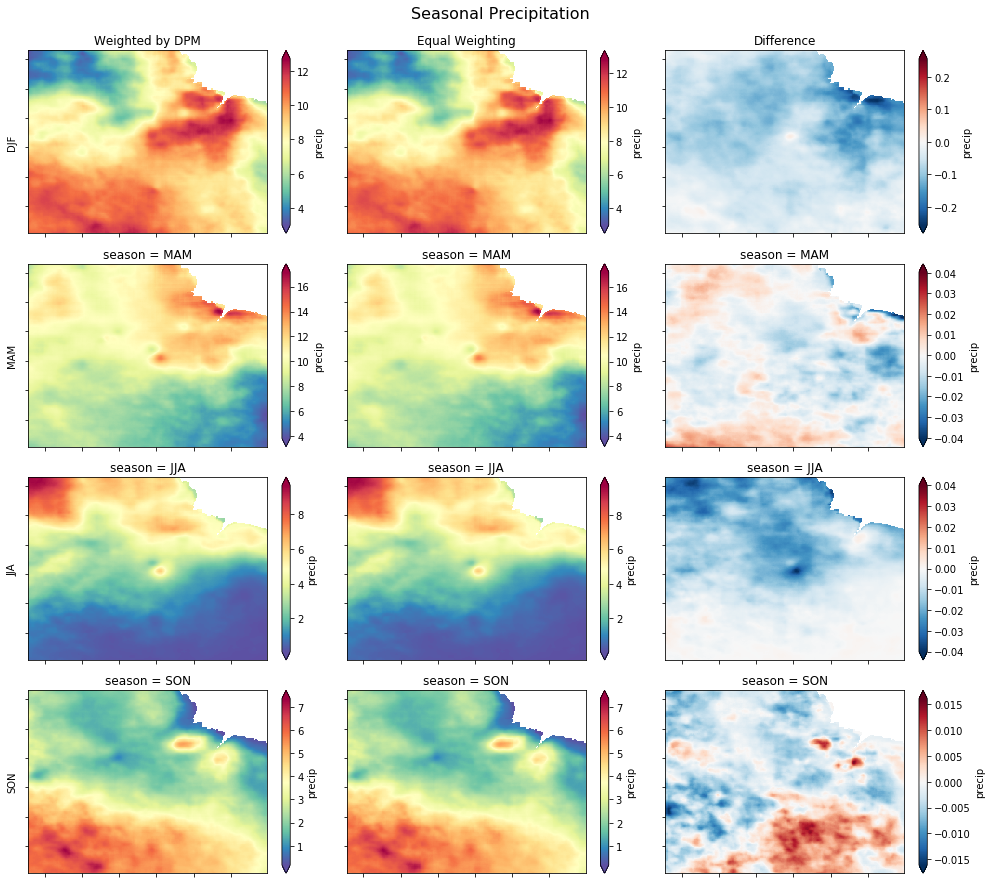

In [447]:
# Quick plot to show the results
notnull = pd.notnull(ds_unweighted['precip'][0])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    ds_weighted['precip'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 0], #vmin=-30, vmax=30, 
        cmap='Spectral_r',
        add_colorbar=True, extend='both')

    ds_unweighted['precip'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 1], #vmin=-30, vmax=30, 
        cmap='Spectral_r',
        add_colorbar=True, extend='both')

    ds_diff['precip'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 2], #vmin=-0.1, vmax=.1, 
        cmap='RdBu_r',
        add_colorbar=True, extend='both')

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')

axes[0, 0].set_title('Weighted by DPM')
axes[0, 1].set_title('Equal Weighting')
axes[0, 2].set_title('Difference')

plt.tight_layout()

fig.suptitle('Seasonal Precipitation', fontsize=16, y=1.02)

# Wrap it all into a simple function:

In [448]:

def season_mean(ds, calendar='standard'):
    # Make a DataArray of season/year groups
    year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
                               coords=[ds.time], name='year_season')

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))
    
    # unweighted:
    ds_unweighted = ds.groupby('time.season').mean('time')
    
    # Calculate the weighted average
    return {'weighted':(ds * weights).groupby('time.season').sum(dim='time'), 'unweighted':ds_unweighted }

In [486]:
Para.rename({'precip':r'$\frac{mm}{hour}$'}, inplace=True)

C:\Users\lealp\AppData\Local\conda\conda\envs\Python_3.7\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  """Entry point for launching an IPython kernel.


<xarray.Dataset>
Dimensions:            (latitude: 249, longitude: 257, time: 13989)
Coordinates:
  * latitude           (latitude) float32 -9.825001 -9.775002 ... 2.574997
  * longitude          (longitude) float32 -58.875008 -58.825005 ... -46.074997
  * time               (time) datetime64[ns] 1981-01-01 ... 2019-04-20
Data variables:
    $\frac{mm}{hour}$  (time, latitude, longitude) float32 11.6181755 ... nan
Attributes:
    Conventions:       CF-1.6
    title:             CHIRP  Version 1.0
    history:           created by Climate Hazards Group
    version:           Version 1.0
    date_created:      2017-10-24
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           
    acknowledgements:  The Climate Hazards Group InfraR

In [487]:
Result = season_mean(Para)

C:\Users\lealp\AppData\Local\conda\conda\envs\Python_3.7\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Making a function to plot the data:

In [635]:
def quick_ploter(Results, variable_name='precip'):
    ds_weighted = Results['weighted']
    ds_unweighted = Results['unweighted']
    
    # Quick plot to show the results
    notnull = pd.notnull(ds_unweighted[variable_name][0])

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
    axes = axes.ravel()
    for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
        mappable = ds_weighted[variable_name].sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i], #vmin=-30, vmax=30, 
            cmap='Spectral_r',
            add_colorbar=True, extend='both', cbar_kwargs={'label':r'$\frac{mm}{hour}$', 'format':'%0.2f'})

        
        axes[i].set_ylabel(season)
        

        #axes[i].axes.get_xaxis().set_ticklabels([])
        #axes[i].axes.get_yaxis().set_ticklabels([])
        axes[i].axes.axis('tight')
        axes[i].set_xlabel('longitude')
        axes[i].set_ylabel('latitude')
        
        

    fig.tight_layout()
    fig.subplots_adjust(top=0.88, hspace=0.5, left=0.05, right=0.92, wspace=0.5)
    fig.suptitle('Seasonal Precipitation', fontsize=16)
    
    return [fig, axes]

# Adding geometries to the plot:

In [636]:
Municipios = gpd.read_file(r'F:\Philipe\Doutorado\BD\IBGE\IBGE_Estruturas_cartograficas_Brasil\2017\Unidades_Censitarias\Municipios\MUNICIPIOS_PARA.shp')

Municipios.to_crs(epsg=4326, inplace=True)



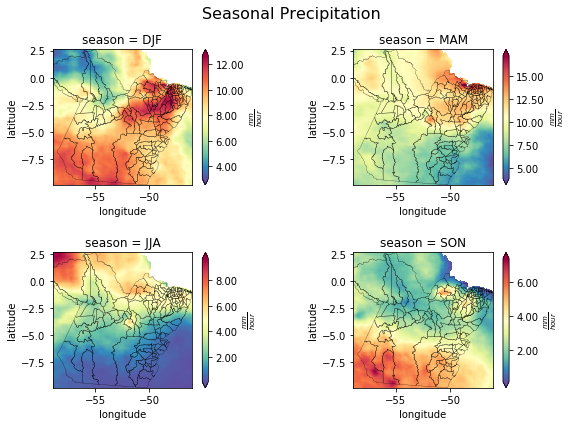

In [637]:


Fig, axes = quick_ploter(Result, variable_name=r'$\frac{mm}{hour}$')

for ax in axes:
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    Municipios.plot(ax=ax, edgecolor='k', facecolor=(1,1,1,0), linewidth=0.22)
    
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Fig.savefig(r'F:\Philipe\Doutorado\Dados_CHIRPS_FTP\Recortados\Seasonal_Precipitation.png', dpi=900) 

# Getting coordinates from original File

## observation: coordinate data can not be altered in netcdf:

## Solution: create another NETCDF from a Dataframe

## Rotating coordinates: 

In [214]:
Para_resampled_mean = Para_resampled_mean.assign_coords(longitude=(((Para_resampled_mean.longitude + 180) % 360) - 180))

Para_resampled_mean

<xarray.Dataset>
Dimensions:    (latitude: 7, longitude: 7)
Coordinates:
  * latitude   (latitude) float64 -9.0 -7.0 -5.0 -3.0 -1.0 1.0 3.0
  * longitude  (longitude) float64 -59.0 -57.0 -55.0 -53.0 -51.0 -49.0 -47.0
Data variables:
    precip     (longitude, latitude) float32 6.40899 6.7028627 ... nan nan

In [62]:
from pyproj import Proj


In [63]:
Polyconical = Proj('+proj=poly +lat_0=0 +lon_0=-54 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs')


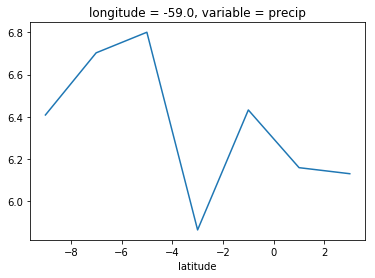

In [56]:
Para_resampled_mean.isel(longitude=0).to_array().plot()

In [84]:
Coords = Para_resampled.drop_dims('time').coords
Coords

Coordinates:
  * latitude   (latitude) float64 -9.0 -7.0 -5.0 -3.0 -1.0 1.0 3.0
  * longitude  (longitude) float64 -59.0 -57.0 -55.0 -53.0 -51.0 -49.0 -47.0

In [254]:
Coords_df = Coords.to_dataset().to_dataframe()

Coords_df.index.names

Coords_df.head().index.values.T[0][1]

-59.0

In [430]:
def reproject_coordinates_in_df(Reprojector, df):

    df['x'] = 0
    df['y'] = 0

    for i in range(len(Coords_df)):
        line = DF.iloc[i]
        
        #print(line.name[0], ': ', Reprojector(line.name[0] , line.name[1]))
        
        df.loc[line.name, 'x'] = Reprojector(line.name[0] , line.name[1])[0]

        df.loc[line.name, 'y'] = Reprojector(line.name[0] , line.name[1])[1]
        
    return df


# To Dataframe:

In [366]:
DF = Para.to_dataframe()

In [432]:
chunks = 200
DF_temp = []
for i in range(chunks):

    DF_temp.append( reproject_coordinates_in_df(Polyconical, DF.iloc[i*200:(i+1)*200]) )

DF_reproj = pd.concat(DF_temp)
    

C:\Users\lealp\AppData\Local\conda\conda\envs\Python_3.7\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lealp\AppData\Local\conda\conda\envs\Python_3.7\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\lealp\AppData\Local\conda\conda\envs\Python_3.7\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is

In [433]:

DF_reproj.set_index(['y', 'x'], inplace=True)

DF_reproj.head()

precip
y            x                      
2.660435e+06 7.367154e+06  11.618176
             7.367154e+06  18.899323
             7.367154e+06  10.114463
             7.367154e+06   6.521374
             7.367154e+06   3.545602

In [434]:
alt = xr.Dataset.from_dataframe(DF_reproj)

alt

ValueError: cannot handle a non-unique multi-index!

In [ ]:
alt.mean(dim='time').to_array()[0].T.plot(label=True)